<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/NewDataset/YOLOv4_YOLOv4%2BBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Darknet

In [1]:
%%capture
!git clone https://github.com/AlexeyAB/darknet

In [2]:
%%capture
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [3]:
%%capture
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [4]:
%%capture
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

In [5]:
%%capture
!apt-get install tree

### Librerías y funciones

In [6]:
import numpy as np
import os,shutil,json
import xml.etree.ElementTree as ET
from pathlib import Path
import glob
import shutil
import operator
import sys
import argparse
import math
from matplotlib import pyplot as plt
import cv2
import json
import os
import re
from pathlib import Path
from imutils.contours import sort_contours
import numpy as np
import imutils
import sys
import statistics as stats
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def mostrarImagen(imagePath):
  image = cv2.imread(imagePath)
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(20,15))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(20,15))
    plt.imshow(img2,cmap='gray')
    plt.show()

def mostrarImagenConAnotacion(imagePath,annotationPath,classesPath):
    image = cv2.imread(imagePath)
    (H,W)=image.shape[:2]
    with open(annotationPath) as f:
        lines = f.readlines()
    with open(classesPath) as f:
        clases = f.readlines()
    for annot in lines:
        (c,x,y,w,h) = annot.split(' ')
        cv2.rectangle(image,(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H)),(int((float(x)+float(w)/2)*W),int((float(y)+float(h)/2)*H)),(0,255,0),10)
        cv2.putText(image,clases[int(c)],(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H-2)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
    img2 = image[:,:,::-1]
    plt.imshow(img2)
    plt.show()


In [44]:
def unconvert(width, height, x, y, w, h):
    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    return ([xmin,ymin, xmax,  ymax])

In [45]:
def non_max_suppression_fast(boxes, overlapThresh=0.3):
  if len(boxes) == 0:
    return []
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  pick = []
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  area=(x2-x1)*(y2-y1)
  idxs = np.argsort(area)
  while len(idxs) > 0:
      i = idxs[0]
      xx1=x1[i]
      xx2=x2[i]
      yy1=y1[i]
      yy2=y2[i]
      x=xx2-xx1
      y=yy2-yy1
      aniadirBbox=True
      for k in idxs[1:]:
        if x1[k]<=xx1+overlapThresh*x and x2[k]>=xx2-overlapThresh*x and y1[k]<=yy1+overlapThresh*y and y2[k]>=yy2-overlapThresh*y:
          aniadirBbox=False
      if aniadirBbox:
        pick.append(i)
      idxs = np.delete(idxs, 0)
  return boxes[pick].astype("int")

In [ ]:
def precision():
  txt=open('output/output.txt','r')
  txt.readline()
  txt.readline()
  l_prec=txt.readline()[13:-2].split()
  return float(l_prec[-1][1:-1])

In [ ]:
def recall():
  txt=open('output/output.txt','r')
  txt.readline()
  txt.readline()
  txt.readline()
  l_prec=txt.readline()[10:-2].split()
  return float(l_prec[-1][1:-1])

In [ ]:
def f1():
  return (2*precision()*recall())/(precision()+recall())

In [ ]:
def abrirImagen(path):
  return cv2.imread(str(path))

#### mAP

In [ ]:
MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored (e.g., python main.py --ignore person book)
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# # argparse receiving list of classes with specific IoU (e.g., python main.py --set-class-iou person 0.7)
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")

args = parser.parse_args()

In [ ]:
def log_average_miss_rate(prec, rec, num_images):
    """
        log-average miss rate:
            Calculated by averaging miss rates at 9 evenly spaced FPPI points
            between 10e-2 and 10e0, in log-space.
        output:
                lamr | log-average miss rate
                mr | miss rate
                fppi | false positives per image
        references:
            [1] Dollar, Piotr, et al. "Pedestrian Detection: An Evaluation of the
               State of the Art." Pattern Analysis and Machine Intelligence, IEEE
               Transactions on 34.4 (2012): 743 - 761.
    """

    # if there were no detections of that class
    if prec.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = (1 - prec)
    mr = (1 - rec)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    # Use 9 evenly spaced reference points in log-space
    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        # np.where() will always find at least 1 index, since min(ref) = 0.01 and min(fppi_tmp) = -1.0
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    # log(0) is undefined, so we use the np.maximum(1e-10, ref)
    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

"""
 throw error and exit
"""
def error(msg):
    print(msg)
    sys.exit(0)

"""
 check if the number is a float between 0.0 and 1.0
"""
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False

"""
 Calculate the AP given the recall and precision array
    1st) We compute a version of the measured precision/recall curve with
         precision monotonically decreasing
    2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


"""
 Convert the lines of a file to a list
"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

"""
 Draws text in image
"""
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    # 
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - pink -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

In [ ]:
def mAP():
  # if there are no classes to ignore then replace None by empty list
  if args.ignore is None:
      args.ignore = []

  specific_iou_flagged = False
  if args.set_class_iou is not None:
      specific_iou_flagged = True

  # make sure that the cwd() is the location of the python script (so that every path makes sense)
  #os.chdir(os.path.dirname(os.path.abspath(__file__)))

  GT_PATH = os.path.join(os.getcwd(), 'input', 'ground-truth')
  DR_PATH = os.path.join(os.getcwd(), 'input', 'detection-results')
  # if there are no images then no animation can be shown
  IMG_PATH = os.path.join(os.getcwd(), 'input', 'images-optional')
  if os.path.exists(IMG_PATH): 
      for dirpath, dirnames, files in os.walk(IMG_PATH):
          if not files:
              # no image files found
              args.no_animation = True
  else:
      args.no_animation = True

  # try to import OpenCV if the user didn't choose the option --no-animation
  show_animation = False
  if not args.no_animation:
      try:
          import cv2
          show_animation = True
      except ImportError:
          print("\"opencv-python\" not found, please install to visualize the results.")
          args.no_animation = True

  # try to import Matplotlib if the user didn't choose the option --no-plot
  draw_plot = False
  if not args.no_plot:
      try:
          import matplotlib.pyplot as plt
          draw_plot = True
      except ImportError:
          print("\"matplotlib\" not found, please install it to get the resulting plots.")
          args.no_plot = True



  """
  Create a ".temp_files/" and "output/" directory
  """
  TEMP_FILES_PATH = ".temp_files"
  if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
      os.makedirs(TEMP_FILES_PATH)
  output_files_path = "output"
  if os.path.exists(output_files_path): # if it exist already
      # reset the output directory
      shutil.rmtree(output_files_path)

  os.makedirs(output_files_path)
  if draw_plot:
      os.makedirs(os.path.join(output_files_path, "classes"))
  if show_animation:
      os.makedirs(os.path.join(output_files_path, "images", "detections_one_by_one"))

  """
  ground-truth
      Load each of the ground-truth files into a temporary ".json" file.
      Create a list of all the class names present in the ground-truth (gt_classes).
  """
  # get a list with the ground-truth files
  ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
  if len(ground_truth_files_list) == 0:
      error("Error: No ground-truth files found!")
  ground_truth_files_list.sort()
  # dictionary with counter per class
  gt_counter_per_class = {}
  counter_images_per_class = {}

  gt_files = []
  for txt_file in ground_truth_files_list:
      #print(txt_file)
      file_id = txt_file.split(".txt", 1)[0]
      file_id = os.path.basename(os.path.normpath(file_id))
      # check if there is a correspondent detection-results file
      temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
      if not os.path.exists(temp_path):
          error_msg = "Error. File not found: {}\n".format(temp_path)
          error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
          error(error_msg)
      lines_list = file_lines_to_list(txt_file)
      # create ground-truth dictionary
      bounding_boxes = []
      is_difficult = False
      already_seen_classes = []
      for line in lines_list:
          try:
              if "difficult" in line:
                      class_name, left, top, right, bottom, _difficult = line.split()
                      is_difficult = True
              else:
                      class_name, left, top, right, bottom = line.split()
          except ValueError:
              error_msg = "Error: File " + txt_file + " in the wrong format.\n"
              error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
              error_msg += " Received: " + line
              error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
              error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
              error(error_msg)
          # check if class is in the ignore list, if yes skip
          if class_name in args.ignore:
              continue
          bbox = left + " " + top + " " + right + " " +bottom
          if is_difficult:
              bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
              is_difficult = False
          else:
              bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
              # count that object
              if class_name in gt_counter_per_class:
                  gt_counter_per_class[class_name] += 1
              else:
                  # if class didn't exist yet
                  gt_counter_per_class[class_name] = 1

              if class_name not in already_seen_classes:
                  if class_name in counter_images_per_class:
                      counter_images_per_class[class_name] += 1
                  else:
                      # if class didn't exist yet
                      counter_images_per_class[class_name] = 1
                  already_seen_classes.append(class_name)


      # dump bounding_boxes into a ".json" file
      new_temp_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
      gt_files.append(new_temp_file)
      with open(new_temp_file, 'w') as outfile:
          json.dump(bounding_boxes, outfile)

  gt_classes = list(gt_counter_per_class.keys())
  # let's sort the classes alphabetically
  gt_classes = sorted(gt_classes)
  n_classes = len(gt_classes)
  #print(gt_classes)
  #print(gt_counter_per_class)

  """
  Check format of the flag --set-class-iou (if used)
      e.g. check if class exists
  """
  if specific_iou_flagged:
      n_args = len(args.set_class_iou)
      error_msg = \
          '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
      if n_args % 2 != 0:
          error('Error, missing arguments. Flag usage:' + error_msg)
      # [class_1] [IoU_1] [class_2] [IoU_2]
      # specific_iou_classes = ['class_1', 'class_2']
      specific_iou_classes = args.set_class_iou[::2] # even
      # iou_list = ['IoU_1', 'IoU_2']
      iou_list = args.set_class_iou[1::2] # odd
      if len(specific_iou_classes) != len(iou_list):
          error('Error, missing arguments. Flag usage:' + error_msg)
      for tmp_class in specific_iou_classes:
          if tmp_class not in gt_classes:
                      error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
      for num in iou_list:
          if not is_float_between_0_and_1(num):
              error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

  """
  detection-results
      Load each of the detection-results files into a temporary ".json" file.
  """
  # get a list with the detection-results files
  dr_files_list = glob.glob(DR_PATH + '/*.txt')
  dr_files_list.sort()

  for class_index, class_name in enumerate(gt_classes):
      bounding_boxes = []
      for txt_file in dr_files_list:
          #print(txt_file)
          # the first time it checks if all the corresponding ground-truth files exist
          file_id = txt_file.split(".txt",1)[0]
          file_id = os.path.basename(os.path.normpath(file_id))
          temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
          if class_index == 0:
              if not os.path.exists(temp_path):
                  error_msg = "Error. File not found: {}\n".format(temp_path)
                  error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                  error(error_msg)
          lines = file_lines_to_list(txt_file)
          for line in lines:
              try:
                  tmp_class_name, confidence, left, top, right, bottom = line.split()
              except ValueError:
                  error_msg = "Error: File " + txt_file + " in the wrong format.\n"
                  error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
                  error_msg += " Received: " + line
                  error(error_msg)
              if tmp_class_name == class_name:
                  #print("match")
                  bbox = left + " " + top + " " + right + " " +bottom
                  bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
                  #print(bounding_boxes)
      # sort detection-results by decreasing confidence
      bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
      with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
          json.dump(bounding_boxes, outfile)

  """
  Calculate the AP for each class
  """
  sum_AP = 0.0
  ap_dictionary = {}
  lamr_dictionary = {}
  # open file to store the output
  with open(output_files_path + "/output.txt", 'w') as output_file:
      output_file.write("# AP and precision/recall per class\n")
      count_true_positives = {}
      for class_index, class_name in enumerate(gt_classes):
          count_true_positives[class_name] = 0
          """
          Load detection-results of that class
          """
          dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
          dr_data = json.load(open(dr_file))

          """
          Assign detection-results to ground-truth objects
          """
          nd = len(dr_data)
          tp = [0] * nd # creates an array of zeros of size nd
          fp = [0] * nd
          for idx, detection in enumerate(dr_data):
              file_id = detection["file_id"]
              if show_animation:
                  # find ground truth image
                  ground_truth_img = glob.glob1(IMG_PATH, file_id + ".*")
                  #tifCounter = len(glob.glob1(myPath,"*.tif"))
                  if len(ground_truth_img) == 0:
                      error("Error. Image not found with id: " + file_id)
                  elif len(ground_truth_img) > 1:
                      error("Error. Multiple image with id: " + file_id)
                  else: # found image
                      #print(IMG_PATH + "/" + ground_truth_img[0])
                      # Load image
                      img = cv2.imread(IMG_PATH + "/" + ground_truth_img[0])
                      # load image with draws of multiple detections
                      img_cumulative_path = output_files_path + "/images/" + ground_truth_img[0]
                      if os.path.isfile(img_cumulative_path):
                          img_cumulative = cv2.imread(img_cumulative_path)
                      else:
                          img_cumulative = img.copy()
                      # Add bottom border to image
                      bottom_border = 60
                      BLACK = [0, 0, 0]
                      img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
              # assign detection-results to ground truth object if any
              # open ground-truth with that file_id
              gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
              ground_truth_data = json.load(open(gt_file))
              ovmax = -1
              gt_match = -1
              # load detected object bounding-box
              bb = [ float(x) for x in detection["bbox"].split() ]
              for obj in ground_truth_data:
                  # look for a class_name match
                  if obj["class_name"] == class_name:
                      bbgt = [ float(x) for x in obj["bbox"].split() ]
                      bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                      iw = bi[2] - bi[0] + 1
                      ih = bi[3] - bi[1] + 1
                      if iw > 0 and ih > 0:
                          # compute overlap (IoU) = area of intersection / area of union
                          ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                          + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                          ov = iw * ih / ua
                          if ov > ovmax:
                              ovmax = ov
                              gt_match = obj

              # assign detection as true positive/don't care/false positive
              if show_animation:
                  status = "NO MATCH FOUND!" # status is only used in the animation
              # set minimum overlap
              min_overlap = MINOVERLAP
              if specific_iou_flagged:
                  if class_name in specific_iou_classes:
                      index = specific_iou_classes.index(class_name)
                      min_overlap = float(iou_list[index])
              if ovmax >= min_overlap:
                  if "difficult" not in gt_match:
                          if not bool(gt_match["used"]):
                              # true positive
                              tp[idx] = 1
                              gt_match["used"] = True
                              count_true_positives[class_name] += 1
                              # update the ".json" file
                              with open(gt_file, 'w') as f:
                                      f.write(json.dumps(ground_truth_data))
                              if show_animation:
                                  status = "MATCH!"
                          else:
                              # false positive (multiple detection)
                              fp[idx] = 1
                              if show_animation:
                                  status = "REPEATED MATCH!"
              else:
                  # false positive
                  fp[idx] = 1
                  if ovmax > 0:
                      status = "INSUFFICIENT OVERLAP"

              """
              Draw image to show animation
              """
              if show_animation:
                  height, widht = img.shape[:2]
                  # colors (OpenCV works with BGR)
                  white = (255,255,255)
                  light_blue = (255,200,100)
                  green = (0,255,0)
                  light_red = (30,30,255)
                  # 1st line
                  margin = 10
                  v_pos = int(height - margin - (bottom_border / 2.0))
                  text = "Image: " + ground_truth_img[0] + " "
                  img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                  text = "Class [" + str(class_index) + "/" + str(n_classes) + "]: " + class_name + " "
                  img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), light_blue, line_width)
                  if ovmax != -1:
                      color = light_red
                      if status == "INSUFFICIENT OVERLAP":
                          text = "IoU: {0:.2f}% ".format(ovmax*100) + "< {0:.2f}% ".format(min_overlap*100)
                      else:
                          text = "IoU: {0:.2f}% ".format(ovmax*100) + ">= {0:.2f}% ".format(min_overlap*100)
                          color = green
                      img, _ = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                  # 2nd line
                  v_pos += int(bottom_border / 2.0)
                  rank_pos = str(idx+1) # rank position (idx starts at 0)
                  text = "Detection #rank: " + rank_pos + " confidence: {0:.2f}% ".format(float(detection["confidence"])*100)
                  img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                  color = light_red
                  if status == "MATCH!":
                      color = green
                  text = "Result: " + status + " "
                  img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)

                  font = cv2.FONT_HERSHEY_SIMPLEX
                  if ovmax > 0: # if there is intersections between the bounding-boxes
                      bbgt = [ int(round(float(x))) for x in gt_match["bbox"].split() ]
                      cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                      cv2.rectangle(img_cumulative,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                      cv2.putText(img_cumulative, class_name, (bbgt[0],bbgt[1] - 5), font, 0.6, light_blue, 1, cv2.LINE_AA)
                  bb = [int(i) for i in bb]
                  cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                  cv2.rectangle(img_cumulative,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                  cv2.putText(img_cumulative, class_name, (bb[0],bb[1] - 5), font, 0.6, color, 1, cv2.LINE_AA)
                  # show image
                  cv2.imshow("Animation", img)
                  cv2.waitKey(20) # show for 20 ms
                  # save image to output
                  output_img_path = output_files_path + "/images/detections_one_by_one/" + class_name + "_detection" + str(idx) + ".jpg"
                  cv2.imwrite(output_img_path, img)
                  # save the image with all the objects drawn to it
                  cv2.imwrite(img_cumulative_path, img_cumulative)

          #print(tp)
          # compute precision/recall
          cumsum = 0
          for idx, val in enumerate(fp):
              fp[idx] += cumsum
              cumsum += val
          cumsum = 0
          for idx, val in enumerate(tp):
              tp[idx] += cumsum
              cumsum += val
          #print(tp)
          rec = tp[:]
          for idx, val in enumerate(tp):
              rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
          #print(rec)
          prec = tp[:]
          for idx, val in enumerate(tp):
              prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
          #print(prec)

          ap, mrec, mprec = voc_ap(rec[:], prec[:])
          sum_AP += ap
          text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)
          """
          Write to output.txt
          """
          rounded_prec = [ '%.2f' % elem for elem in prec ]
          rounded_rec = [ '%.2f' % elem for elem in rec ]
          output_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
          if not args.quiet:
              print(text)
          ap_dictionary[class_name] = ap

          n_images = counter_images_per_class[class_name]
          lamr, mr, fppi = log_average_miss_rate(np.array(prec), np.array(rec), n_images)
          lamr_dictionary[class_name] = lamr

          """
          Draw plot
          """
          if draw_plot:
              plt.plot(rec, prec, '-o')
              # add a new penultimate point to the list (mrec[-2], 0.0)
              # since the last line segment (and respective area) do not affect the AP value
              area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
              area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
              plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')
              # set window title
              fig = plt.gcf() # gcf - get current figure
              fig.canvas.set_window_title('AP ' + class_name)
              # set plot title
              plt.title('class: ' + text)
              #plt.suptitle('This is a somewhat long figure title', fontsize=16)
              # set axis titles
              plt.xlabel('Recall')
              plt.ylabel('Precision')
              # optional - set axes
              axes = plt.gca() # gca - get current axes
              axes.set_xlim([0.0,1.0])
              axes.set_ylim([0.0,1.05]) # .05 to give some extra space
              # Alternative option -> wait for button to be pressed
              #while not plt.waitforbuttonpress(): pass # wait for key display
              # Alternative option -> normal display
              #plt.show()
              # save the plot
              fig.savefig(output_files_path + "/classes/" + class_name + ".png")
              plt.cla() # clear axes for next plot

      if show_animation:
          cv2.destroyAllWindows()

      output_file.write("\n# mAP of all classes\n")
      mAP = sum_AP / n_classes
      text = "mAP = {0:.2f}%".format(mAP*100)
      output_file.write(text + "\n")
      print(text)

  """
  Draw false negatives
  """
  if show_animation:
      pink = (203,192,255)
      for tmp_file in gt_files:
          ground_truth_data = json.load(open(tmp_file))
          #print(ground_truth_data)
          # get name of corresponding image
          start = TEMP_FILES_PATH + '/'
          img_id = tmp_file[tmp_file.find(start)+len(start):tmp_file.rfind('_ground_truth.json')]
          img_cumulative_path = output_files_path + "/images/" + img_id + ".jpg"
          img = cv2.imread(img_cumulative_path)
          if img is None:
              img_path = IMG_PATH + '/' + img_id + ".jpg"
              img = cv2.imread(img_path)
          # draw false negatives
          for obj in ground_truth_data:
              if not obj['used']:
                  bbgt = [ int(round(float(x))) for x in obj["bbox"].split() ]
                  cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),pink,2)
          cv2.imwrite(img_cumulative_path, img)

  # remove the temp_files directory
  shutil.rmtree(TEMP_FILES_PATH)

  """
  Count total of detection-results
  """
  # iterate through all the files
  det_counter_per_class = {}
  for txt_file in dr_files_list:
      # get lines to list
      lines_list = file_lines_to_list(txt_file)
      for line in lines_list:
          class_name = line.split()[0]
          # check if class is in the ignore list, if yes skip
          if class_name in args.ignore:
              continue
          # count that object
          if class_name in det_counter_per_class:
              det_counter_per_class[class_name] += 1
          else:
              # if class didn't exist yet
              det_counter_per_class[class_name] = 1
  #print(det_counter_per_class)
  dr_classes = list(det_counter_per_class.keys())


  """
  Plot the total number of occurences of each class in the ground-truth
  """
  if draw_plot:
      window_title = "ground-truth-info"
      plot_title = "ground-truth\n"
      plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
      x_label = "Number of objects per class"
      output_path = output_files_path + "/ground-truth-info.png"
      to_show = False
      plot_color = 'forestgreen'
      draw_plot_func(
          gt_counter_per_class,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          '',
          )

  """
  Write number of ground-truth objects per class to results.txt
  """
  with open(output_files_path + "/output.txt", 'a') as output_file:
      output_file.write("\n# Number of ground-truth objects per class\n")
      for class_name in sorted(gt_counter_per_class):
          output_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")

  """
  Finish counting true positives
  """
  for class_name in dr_classes:
      # if class exists in detection-result but not in ground-truth then there are no true positives in that class
      if class_name not in gt_classes:
          count_true_positives[class_name] = 0
  #print(count_true_positives)

  """
  Plot the total number of occurences of each class in the "detection-results" folder
  """
  if draw_plot:
      window_title = "detection-results-info"
      # Plot title
      plot_title = "detection-results\n"
      plot_title += "(" + str(len(dr_files_list)) + " files and "
      count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(det_counter_per_class.values()))
      plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
      # end Plot title
      x_label = "Number of objects per class"
      output_path = output_files_path + "/detection-results-info.png"
      to_show = False
      plot_color = 'forestgreen'
      true_p_bar = count_true_positives
      draw_plot_func(
          det_counter_per_class,
          len(det_counter_per_class),
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          true_p_bar
          )

  """
  Write number of detected objects per class to output.txt
  """
  with open(output_files_path + "/output.txt", 'a') as output_file:
      output_file.write("\n# Number of detected objects per class\n")
      for class_name in sorted(dr_classes):
          n_det = det_counter_per_class[class_name]
          text = class_name + ": " + str(n_det)
          text += " (tp:" + str(count_true_positives[class_name]) + ""
          text += ", fp:" + str(n_det - count_true_positives[class_name]) + ")\n"
          output_file.write(text)

  """
  Draw log-average miss rate plot (Show lamr of all classes in decreasing order)
  """
  if draw_plot:
      window_title = "lamr"
      plot_title = "log-average miss rate"
      x_label = "log-average miss rate"
      output_path = output_files_path + "/lamr.png"
      to_show = False
      plot_color = 'royalblue'
      draw_plot_func(
          lamr_dictionary,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          ""
          )

  """
  Draw mAP plot (Show AP's of all classes in decreasing order)
  """
  if draw_plot:
      window_title = "mAP"
      plot_title = "mAP = {0:.2f}%".format(mAP*100)
      x_label = "Average Precision"
      output_path = output_files_path + "/mAP.png"
      to_show = False
      plot_color = 'royalblue'
      draw_plot_func(
          ap_dictionary,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          ""
          )

## Descarga de archivos

In [8]:
%%capture
!wget https://www.dropbox.com/s/wxzrfb5wtdgdgi8/funsd_last.weights?dl=0 -O funsd_last.weights
!wget https://www.dropbox.com/s/2hdgc14avqle31s/funsd.cfg?dl=0 -O funsd.cfg
!wget https://www.dropbox.com/s/eaf1sp3k1xoig7h/funsd.data?dl=0 -O funsd.data
!wget https://www.dropbox.com/s/vwxyeohq1amz369/funsd.names?dl=0 -O funsd.names

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!unzip /content/drive/MyDrive/Athento/FacturasYOLO.zip

Archive:  /content/drive/MyDrive/Athento/FacturasYOLO.zip
  inflating: FacturasYOLO/01.jpg     
  inflating: FacturasYOLO/01.txt     
  inflating: FacturasYOLO/02.jpg     
  inflating: FacturasYOLO/02.txt     
  inflating: FacturasYOLO/03.jpg     
  inflating: FacturasYOLO/03.txt     
  inflating: FacturasYOLO/04.jpg     
  inflating: FacturasYOLO/04.txt     
  inflating: FacturasYOLO/05.jpg     
  inflating: FacturasYOLO/05.txt     
  inflating: FacturasYOLO/06.jpg     
  inflating: FacturasYOLO/06.txt     
  inflating: FacturasYOLO/07.jpg     
  inflating: FacturasYOLO/07.txt     
  inflating: FacturasYOLO/08.jpg     
  inflating: FacturasYOLO/08.txt     
  inflating: FacturasYOLO/09.jpg     
  inflating: FacturasYOLO/09.txt     
  inflating: FacturasYOLO/10.jpg     
  inflating: FacturasYOLO/10.txt     
  inflating: FacturasYOLO/11.jpg     
  inflating: FacturasYOLO/11.txt     
  inflating: FacturasYOLO/12.jpg     
  inflating: FacturasYOLO/12.txt     
  inflating: FacturasYOLO/13.j

In [11]:
path='FacturasYOLO'
files = [Path(str(path)+'/'+p) for p in os.listdir(path) if p[-1]=='g']

In [12]:
txt=open('test.txt','w')
for f in files:
  txt.write(str(f)+'\n')
txt.close() 

In [13]:
txt=open('classes.data','w')
txt.write('classes = 4\n')
txt.write('train  = train.txt\n')
txt.write('valid  = test.txt\n')
txt.write('names = funsd.names\n')
txt.write('backup = FUNSDdataset/\n')
txt.close() 

In [14]:
!cp funsd.cfg ./cfg

## **YOLOv4**

### Detección

In [ ]:
!./darknet detector map classes.data cfg/funsd.cfg funsd_last.weights -iou_thresh 0.50 -points 101

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     80       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  80 4.719 BF
   2 conv     40       1 x 1/ 1    320 x 320 x  80 ->  320 x 320 x  40 0.655 BF
   3 conv     80       3 x 3/ 1    320 x 320 x  40 ->  320 x 320 x  80 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  80 0.008 BF
   5 conv    160       3 x 3/ 2    320 x 320 x  80 ->  160 x 160 x 160 5.898 BF
   6 conv     80       1 x 1/ 1    160 x 160 x 160 ->  160 x 160 x  80 0.655 BF
   7 route  5 		                           ->  160 x 160 x 160 
   8 conv  

mAP= 16.60 %

precision = 0.31 

recall = 0.34 

F1-score = 0.32

In [15]:
%cd cfg
!sed -i 's/batch=64/batch=1/' funsd.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' funsd.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [92]:
!./darknet detector test classes.data cfg/funsd.cfg funsd_last.weights FacturasYOLO/01.jpg -thresh 0.3

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     80       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  80 4.719 BF
   2 conv     40       1 x 1/ 1    320 x 320 x  80 ->  320 x 320 x  40 0.655 BF
   3 conv     80       3 x 3/ 1    320 x 320 x  40 ->  320 x 320 x  80 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  80 0.008 BF
   5 conv    160       3 x 3/ 2    320 x 320 x  80 ->  160 x 160 x 160 5.898 BF
   6 conv     80       1 x 1/ 1    160 x 160 x 160 ->  160 x 160 x  80 0.655 BF
   7 route  5 		                           ->  160 x 160 x 160 
   8 conv  

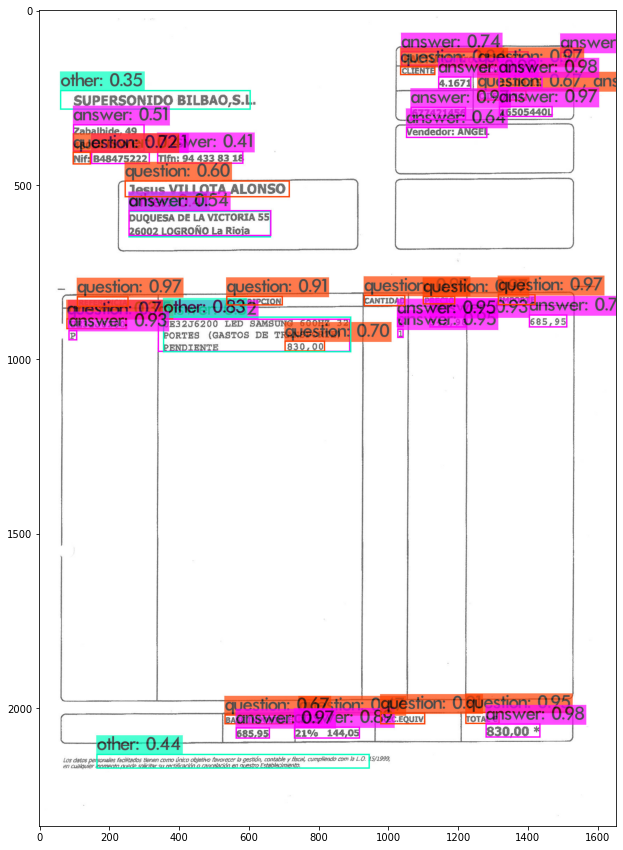

In [93]:
mostrarImagen(abrirImagen('predictions.jpg'))

#### Reescalamos las imagenes

In [ ]:
import cv2
from shutil import copyfile
%mkdir newFacturas
for f in files:
  image = cv2.imread(str(f))
  imageOut = cv2.resize(image,(754,1000), interpolation=cv2.INTER_CUBIC)
  cv2.imwrite(str(Path('newFacturas')/f.name),imageOut)
  name=f.stem+'.txt'
  copyfile(f.parent/name, Path('newFacturas')/name)

In [ ]:
path='newFacturas'
files = [Path(str(path)+'/'+p) for p in os.listdir(path) if p[-1]=='g']

In [ ]:
txt=open('test.txt','w')
for f in files:
  txt.write(str(f)+'\n')
txt.close() 

In [ ]:
!./darknet detector map classes.data cfg/funsd.cfg funsd_last.weights -iou_thresh 0.50 -points 101

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     80       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  80 4.719 BF
   2 conv     40       1 x 1/ 1    320 x 320 x  80 ->  320 x 320 x  40 0.655 BF
   3 conv     80       3 x 3/ 1    320 x 320 x  40 ->  320 x 320 x  80 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  80 0.008 BF
   5 conv    160       3 x 3/ 2    320 x 320 x  80 ->  160 x 160 x 160 5.898 BF
   6 conv     80       1 x 1/ 1    160 x 160 x 160 ->  160 x 160 x  80 0.655 BF
   7 route  5 		                           ->  160 x 160 x 160 
   8 conv  

mAP= 15.24 %

precision = 0.30 

recall = 0.33 

F1-score = 0.31

### Localización

In [36]:
!./darknet detector test classes.data cfg/funsd.cfg funsd_last.weights -ext_output -dont_show -out result.json < test.txt

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     80       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  80 4.719 BF
   2 conv     40       1 x 1/ 1    320 x 320 x  80 ->  320 x 320 x  40 0.655 BF
   3 conv     80       3 x 3/ 1    320 x 320 x  40 ->  320 x 320 x  80 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  80 0.008 BF
   5 conv    160       3 x 3/ 2    320 x 320 x  80 ->  160 x 160 x 160 5.898 BF
   6 conv     80       1 x 1/ 1    160 x 160 x 160 ->  160 x 160 x  80 0.655 BF
   7 route  5 		                           ->  160 x 160 x 160 
   8 conv  

In [37]:
resultado=json.loads(open('result.json').read())

In [ ]:
%mkdir 'input'
%mkdir 'input/ground-truth'
%mkdir 'input/detection-results'

In [ ]:
!unzip Facturas.zip

In [ ]:
path='Facturas'
for file in [xml for xml in os.listdir(path) if xml[-1]=='l']:
  txt=open('input/ground-truth/'+file[:-4]+'.txt','w')
  path_file=path+'/'+file
  objeto=ET.parse(path_file)
  objeto = objeto.getroot()
  for bbox in objeto.findall('object'):
    label=bbox.find('name').text
    coords = bbox.find('bndbox')
    xmin,ymin,xmax,ymax = coords.find('xmin').text,coords.find('ymin').text,coords.find('xmax').text,coords.find('ymax').text
    txt.write('0' + ' ' + xmin + ' ' + ymin + ' '+ xmax + ' '+ ymax +'\n')
  txt.close()

Non Max Supression

In [ ]:
resultado=json.loads(open('result.json').read())
for res in resultado:
  txt=open('input/detection-results/'+Path(res['filename']).stem+'.txt','w')
  img=cv2.imread(res['filename'])
  height,width,_=img.shape
  conf=[]
  l=[]
  for objeto in res['objects']:
    conf.append(objeto['confidence'])
    coords=objeto['relative_coordinates']
    x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
    l.append(unconvert(width, height, x, y, w, h))
  dic={str(l[i]):str(conf[i]) for i in range(0,len(l))}
  l=non_max_suppression_fast(np.array(l))
  for x in l:
    xmin,ymin,xmax,ymax=x
    confi=dic[str(list(x))]
    txt.write('0' + ' ' +str(int(float(confi)*100)) + ' '+ str(xmin) + ' ' + str(ymin) + ' '+ str(xmax) + ' '+ str(ymax) +'\n')
  txt.close()

#### Resultados

In [ ]:
mAP()

46.91% = 0 AP 
mAP = 46.91%


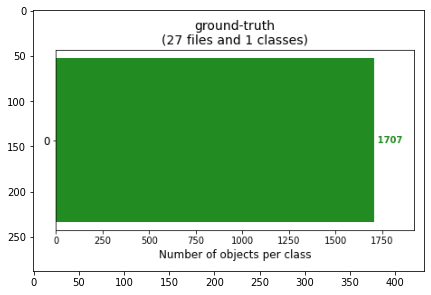

In [ ]:
mostrarImagen(abrirImagen('output/ground-truth-info.png'),7,5)

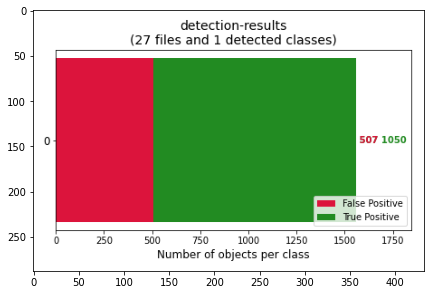

In [ ]:
mostrarImagen(abrirImagen('output/detection-results-info.png'),7,5)

In [ ]:
precision()

0.67

In [ ]:
recall()

0.62

In [ ]:
f1()

0.644031007751938

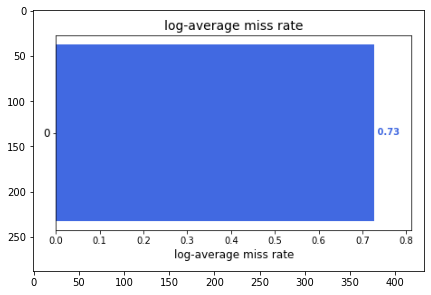

In [ ]:
mostrarImagen(abrirImagen('output/lamr.png'),7,5)

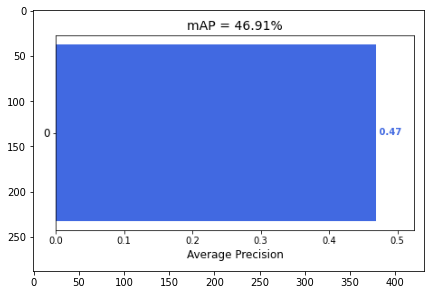

In [ ]:
mostrarImagen(abrirImagen('output/mAP.png'),7,5)

In [ ]:
files=[path+'/'+jpg for jpg in os.listdir(path) if jpg[-1]=='g']

## **YOLOv4 + BERT**

##### Cargamos las librerías necesarias y los modelos necesarios

In [ ]:
!./darknet detector test classes.data cfg/funsd.cfg funsd_last.weights -ext_output -dont_show -out result.json < test.txt

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     80       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  80 4.719 BF
   2 conv     40       1 x 1/ 1    320 x 320 x  80 ->  320 x 320 x  40 0.655 BF
   3 conv     80       3 x 3/ 1    320 x 320 x  40 ->  320 x 320 x  80 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  80 0.008 BF
   5 conv    160       3 x 3/ 2    320 x 320 x  80 ->  160 x 160 x 160 5.898 BF
   6 conv     80       1 x 1/ 1    160 x 160 x 160 ->  160 x 160 x  80 0.655 BF
   7 route  5 		                           ->  160 x 160 x 160 
   8 conv  

In [46]:
resultado=json.loads(open('result.json').read())

In [ ]:
!unzip Facturas.zip

In [16]:
%%capture
pip install transformers

In [17]:
from transformers import BertForSequenceClassification,BertTokenizer, Trainer

In [18]:
%%capture
!wget https://www.dropbox.com/s/rez0qxprg2mgke5/bert.zip?dl=0 -O bert.zip
!unzip bert

In [ ]:
!unzip Facturas.zip

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [20]:
model = BertForSequenceClassification.from_pretrained('bert')
tokenizer = BertTokenizer.from_pretrained('bert')
trainer = Trainer(model,compute_metrics=compute_metrics)

In [21]:
%%capture
!sudo apt install tesseract-ocr

In [22]:
%%capture
pip install pytesseract

In [23]:
from pytesseract import Output
import pytesseract
import argparse

In [24]:
def ocr(l,img):
  C=[]
  T=[]
  for x in l:
    image=img[x[1]:x[3],x[0]:x[2]]
    c=[]
    t=[]

    #Imagen con borde +2
    shape=image.shape
    w=shape[1]
    h=shape[0]
    base_size=h+4,w+4,3
    base=np.zeros(base_size,dtype=np.uint8)
    cv2.rectangle(base,(0,0),(w+4,h+4),(255,255,255),30)
    base[2:h+2,2:w+2]=image

    #OCR
    results = pytesseract.image_to_data(base, output_type=Output.DICT)
    c.append(float(media(results['conf'])))
    t.append(' '.join(results['text']))


    c1=[]
    t1=[]
    #Imagen con borde +3
    base_size=h+6,w+6,3
    base1=np.zeros(base_size,dtype=np.uint8)
    cv2.rectangle(base1,(0,0),(w+6,h+6),(255,255,255),30)
    base1[3:h+3,3:w+3]=image

    #OCR
    results = pytesseract.image_to_data(base1, output_type=Output.DICT)
    c1.append(float(media(results['conf'])))
    t1.append(' '.join(results['text']))

    # Ya tenemos todos los resultados almacenados, ahora buscamos al mejor
    max_c=(max(c))
    index=c.index(max_c)
    x=t[index]

    max_c1=(max(c1))
    index1=c1.index(max_c1)
    y=t1[index1]
    if max_c>max_c1:
      C.append(max_c)
      if x.replace(' ','')!='':
        T.append(x)

      else:
        T.append(y)

    else:
       C.append(max_c1)
       if y.replace(' ','')!='':
         T.append(y)
  
       else:
         T.append(x)
 
  return (C,T)

In [25]:
def media(lista):
  i,sum=0,0
  for x in lista:
    if x!='-1':
      i+=1
      sum=x+sum
  if i==0:
    return sum
  return "{0:.2f}".format(sum/i)

In [26]:
class Dataset():
    def __init__(self, txt):
        self.txt= txt
        self.encodings = tokenizer(txt, truncation=True, padding=True)

    def __iter__(self):
        for x in self.txt:
          yield x
    def __len__(self):
      return len(self.txt)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.txt)

In [27]:
def abrirImagen(path):
  return cv2.imread(str(path))

In [28]:
def mostrarImagen(image,h=20,w=15):
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(h,w))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(h,w))
    plt.imshow(img2,cmap='gray')
    plt.show()

In [29]:
def listaCont(path):
  img=abrirImagen(path)
  gray=cv2.cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray= cv2.GaussianBlur(gray, (5,5), 0)
  (H,W)=gray.shape
  coef1=H//75
  coef2=W//150
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(coef1,coef2))
  sqKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(coef1,coef1))
  blackhat= cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,rectKernel)
  grad= cv2.Sobel(blackhat,ddepth=cv2.CV_32F,dx=1,dy=0,ksize=-1)
  grad=np.absolute(grad)
  (minVal, maxVal)=(np.min(grad),np.max(grad))
  grad= (grad-minVal)/(maxVal-minVal)
  grad= (grad*255).astype("uint8")
  grad=cv2.morphologyEx(grad,cv2.MORPH_CLOSE,rectKernel)
  lineas = cv2.erode(grad,kernel = np.ones((40,1)))
  final=grad-lineas
  thresh=cv2.threshold(final, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  cnts= cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts=imutils.grab_contours(cnts)
  clone=img.copy()
  l=[]
  for c in cnts:
      area = cv2.contourArea(c)
      (x, y, w, h) = cv2.boundingRect(c)
      if area>50 and x+w> 0.1*img.shape[1] and x<0.9*img.shape[1] and y<0.93*img.shape[0] and h<0.5*img.shape[0] and w>0.5*h:
        l=l+[[x,y,x + w, y + h]]
  return l,img

In [38]:
def abrirImagen(path):
  return cv2.imread(str(path))

In [39]:
def mostrarImagen(image,h=20,w=15):
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(h,w))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(h,w))
    plt.imshow(img2,cmap='gray')
    plt.show()

### Ground truth

In [ ]:
os.rename('input', 'input_1')

In [30]:
%mkdir 'input'
%mkdir 'input/ground-truth'
%mkdir 'input/detection-results'

In [33]:
path='Facturas'
for file in [xml for xml in os.listdir(path) if xml[-1]=='l']:
  txt=open('input/ground-truth/'+file[:-4]+'.txt','w')
  path_file=path+'/'+file
  objeto=ET.parse(path_file)
  objeto = objeto.getroot()
  for bbox in objeto.findall('object'):
    label=bbox.find('name').text
    coords = bbox.find('bndbox')
    xmin,ymin,xmax,ymax = coords.find('xmin').text,coords.find('ymin').text,coords.find('xmax').text,coords.find('ymax').text
    txt.write(label + ' ' + xmin + ' ' + ymin + ' '+ xmax + ' '+ ymax +'\n')
  txt.close()

### Sin traductor

#### Predicciones

In [47]:
for res in resultado:
  txt=open('input/detection-results/'+Path(res['filename']).stem+'.txt','w')
  img=cv2.imread(res['filename'])
  height,width,_=img.shape
  conf=[]
  l=[]
  for objeto in res['objects']:
    conf.append(objeto['confidence'])
    coords=objeto['relative_coordinates']
    x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
    l.append(unconvert(width, height, x, y, w, h))
  dic={str(l[i]):str(conf[i]) for i in range(0,len(l))}
  l=non_max_suppression_fast(np.array(l))
  test_conf,test_text=ocr(l,img)
  test_dataset = Dataset(test_text)
  prediction=trainer.predict(test_dataset)
  output=prediction[0].argmax(-1)
  dic_1={0:'question', 1:'answer', 2:'header', 3:'other'}
  output=[dic_1[x] for x in output]
  f=Path(res['filename'])
  txt=open('input/detection-results/'+f.stem+'.txt','w')
  for i in range(0,len(l)):
    logit=output[i]
    x, y, z, w=l[i]
    conf=float(dic[str(list(l[i]))])
    conf1=test_conf[i]
    txt.write(logit + ' ' +str(int((conf+conf1)/2)) + ' '+ str(x) + ' ' + str(y) + ' '+ str(z) + ' '+ str(w) +'\n')
  txt.close()

***** Running Prediction *****
  Num examples = 137
  Batch size = 8


***** Running Prediction *****
  Num examples = 20
  Batch size = 8
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
***** Running Prediction *****
  Num examples = 56
  Batch size = 8
***** Running Prediction *****
  Num examples = 52
  Batch size = 8
***** Running Prediction *****
  Num examples = 83
  Batch size = 8
***** Running Prediction *****
  Num examples = 68
  Batch size = 8
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
***** Running Prediction *****
  Num examples = 86
  Batch size = 8
***** Running Prediction *****
  Num examples = 37
  Batch size = 8
***** Running Prediction *****
  Num examples = 69
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 48
  Batch size = 8
***** Running Prediction *****
  Num examples = 50
  Batch size = 8
***** Running Prediction *****
  Num examples = 

#### Resultados

In [48]:
mAP()

22.89% = answer AP 
0.00% = header AP 
4.49% = other AP 
23.04% = question AP 
mAP = 12.61%


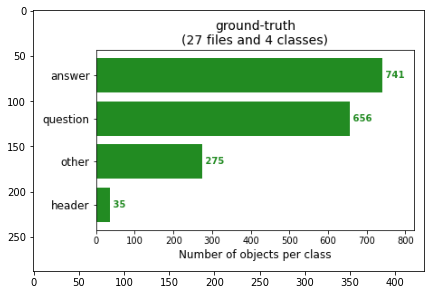

In [49]:
mostrarImagen(abrirImagen('output/ground-truth-info.png'),7,5)

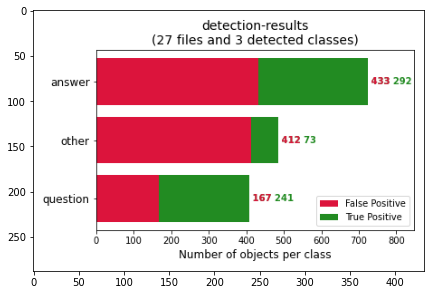

In [50]:
mostrarImagen(abrirImagen('output/detection-results-info.png'),7,5)

In [51]:
precision=292/741+73/656+241/275
precision=precision/4
precision

0.3454265506102797

In [52]:
recall=292/(292+433)+73/(73+412)+241/(167+241)
recall=recall/4
recall

0.2859900897792462

In [53]:
f1=2*precision*recall/(precision+recall)
f1

0.3129108860996308

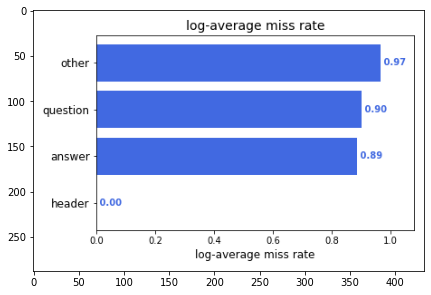

In [54]:
mostrarImagen(abrirImagen('output/lamr.png'),7,5)

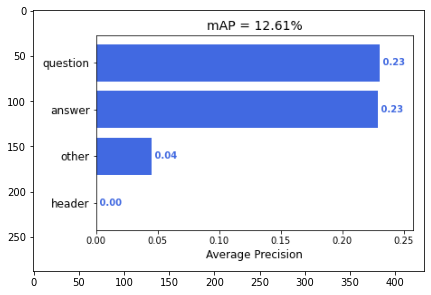

In [55]:
mostrarImagen(abrirImagen('output/mAP.png'),7,5)

### Traductor

In [56]:
%%capture
!pip3 install googletrans==3.1.0a0

In [57]:
from googletrans import Translator, constants
from pprint import pprint

In [58]:
translator = Translator()

#### Predicciones

In [64]:
for res in resultado:
  txt=open('input/detection-results/'+Path(res['filename']).stem+'.txt','w')
  img=cv2.imread(res['filename'])
  height,width,_=img.shape
  conf=[]
  l=[]
  for objeto in res['objects']:
    conf.append(objeto['confidence'])
    coords=objeto['relative_coordinates']
    x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
    l.append(unconvert(width, height, x, y, w, h))
  dic={str(l[i]):str(conf[i]) for i in range(0,len(l))}
  l=non_max_suppression_fast(np.array(l))
  test_conf,test_text=ocr(l,img)
  for i in range(0,len(test_text)):
    test_text[i]=' '.join(test_text[i].split())
    if test_text[i]!='':
      test_text[i] = translator.translate(test_text[i], src='es', dest="en").text
  test_dataset = Dataset(test_text)
  prediction=trainer.predict(test_dataset)
  output=prediction[0].argmax(-1)
  dic_1={0:'question', 1:'answer', 2:'header', 3:'other'}
  output=[dic_1[x] for x in output]
  f=Path(res['filename'])
  txt=open('input/detection-results/'+f.stem+'.txt','w')
  for i in range(0,len(l)):
    logit=output[i]
    x, y, z, w=l[i]
    conf=float(dic[str(list(l[i]))])
    conf1=test_conf[i]
    txt.write(logit + ' ' +str(int((conf+conf1)/2)) + ' '+ str(x) + ' ' + str(y) + ' '+ str(z) + ' '+ str(w) +'\n')
  txt.close()

***** Running Prediction *****
  Num examples = 137
  Batch size = 8


***** Running Prediction *****
  Num examples = 20
  Batch size = 8
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
***** Running Prediction *****
  Num examples = 56
  Batch size = 8
***** Running Prediction *****
  Num examples = 52
  Batch size = 8
***** Running Prediction *****
  Num examples = 83
  Batch size = 8
***** Running Prediction *****
  Num examples = 68
  Batch size = 8
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
***** Running Prediction *****
  Num examples = 86
  Batch size = 8
***** Running Prediction *****
  Num examples = 37
  Batch size = 8
***** Running Prediction *****
  Num examples = 69
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 48
  Batch size = 8
***** Running Prediction *****
  Num examples = 50
  Batch size = 8
***** Running Prediction *****
  Num examples = 

#### Resultados

In [65]:
mAP()

22.81% = answer AP 
0.95% = header AP 
4.82% = other AP 
22.77% = question AP 
mAP = 12.84%


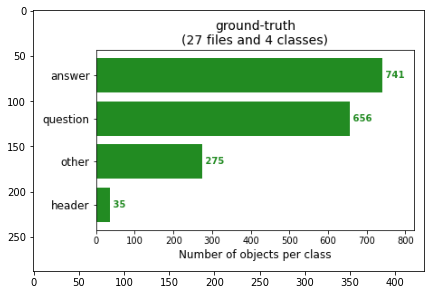

In [66]:
mostrarImagen(abrirImagen('output/ground-truth-info.png'),7,5)

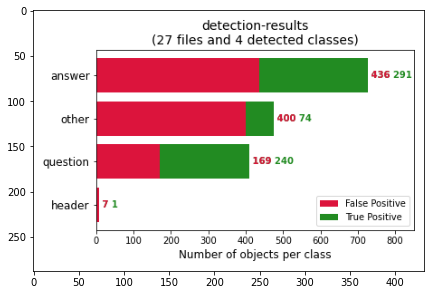

In [67]:
mostrarImagen(abrirImagen('output/detection-results-info.png'),7,5)

In [83]:
precision=291/741+74/656+240/275
precision=precision/4
precision

0.3445611753458352

In [84]:
recall=291/(292+436)+74/(74+400)+240/(169+240)
recall=recall/4
recall

0.2856601210499651

In [85]:
f1=2*precision*recall/(precision+recall)
f1

0.3123581752038852

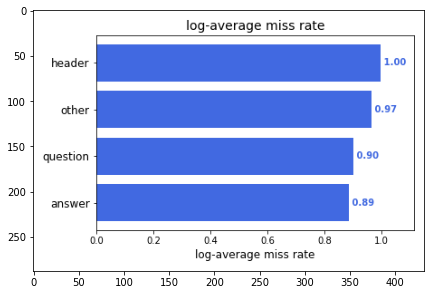

In [71]:
mostrarImagen(abrirImagen('output/lamr.png'),7,5)

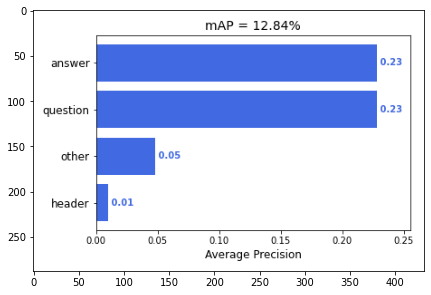

In [72]:
mostrarImagen(abrirImagen('output/mAP.png'),7,5)

###Corrector

In [73]:
%%capture
!pip install autocorrect
from autocorrect import Speller
spell = Speller(lang='es',only_replacements=True)

#### Predicciones

In [74]:
for res in resultado:
  txt=open('input/detection-results/'+Path(res['filename']).stem+'.txt','w')
  img=cv2.imread(res['filename'])
  height,width,_=img.shape
  conf=[]
  l=[]
  for objeto in res['objects']:
    conf.append(objeto['confidence'])
    coords=objeto['relative_coordinates']
    x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
    l.append(unconvert(width, height, x, y, w, h))
  dic={str(l[i]):str(conf[i]) for i in range(0,len(l))}
  l=non_max_suppression_fast(np.array(l))
  test_conf,test_text=ocr(l,img)
  for i in range(0,len(test_text)):
    test_text[i]=' '.join(test_text[i].split())
    if test_text[i]!='':
      test_text[i]=translator.translate(spell(test_text[i].lower()), src="es",dest="en").text
  test_dataset = Dataset(test_text)
  prediction=trainer.predict(test_dataset)
  output=prediction[0].argmax(-1)
  dic_1={0:'question', 1:'answer', 2:'header', 3:'other'}
  output=[dic_1[x] for x in output]
  f=Path(res['filename'])
  txt=open('input/detection-results/'+f.stem+'.txt','w')
  for i in range(0,len(l)):
    logit=output[i]
    x, y, z, w=l[i]
    conf=float(dic[str(list(l[i]))])
    conf1=test_conf[i]
    txt.write(logit + ' ' +str(int((conf+conf1)/2)) + ' '+ str(x) + ' ' + str(y) + ' '+ str(z) + ' '+ str(w) +'\n')
  txt.close()
spell = Speller(lang='es',only_replacements=True)

***** Running Prediction *****
  Num examples = 137
  Batch size = 8


***** Running Prediction *****
  Num examples = 20
  Batch size = 8
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
***** Running Prediction *****
  Num examples = 56
  Batch size = 8
***** Running Prediction *****
  Num examples = 52
  Batch size = 8
***** Running Prediction *****
  Num examples = 83
  Batch size = 8
***** Running Prediction *****
  Num examples = 68
  Batch size = 8
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
***** Running Prediction *****
  Num examples = 86
  Batch size = 8
***** Running Prediction *****
  Num examples = 37
  Batch size = 8
***** Running Prediction *****
  Num examples = 69
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 48
  Batch size = 8
***** Running Prediction *****
  Num examples = 50
  Batch size = 8
***** Running Prediction *****
  Num examples = 

#### Resultados

In [75]:
mAP()

22.57% = answer AP 
0.00% = header AP 
4.41% = other AP 
22.78% = question AP 
mAP = 12.44%


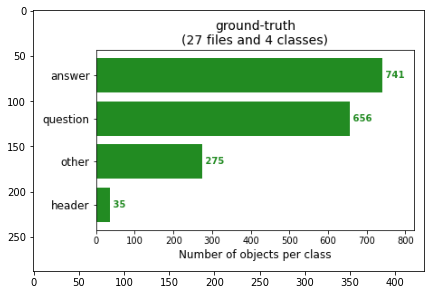

In [76]:
mostrarImagen(abrirImagen('output/ground-truth-info.png'),7,5)

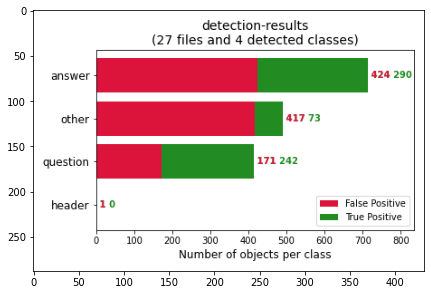

In [77]:
mostrarImagen(abrirImagen('output/detection-results-info.png'),7,5)

In [78]:
precision=290/741+73/656+242/275
precision=precision/4
precision

0.34566087768671205

In [79]:
recall=290/(290+424)+73/(73+417)+242/(171+242)
recall=recall/4
recall

0.28527461832190504

In [80]:
f1=2*precision*recall/(precision+recall)
f1

0.31257799117247553

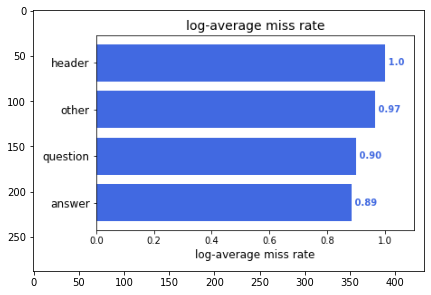

In [81]:
mostrarImagen(abrirImagen('output/lamr.png'),7,5)

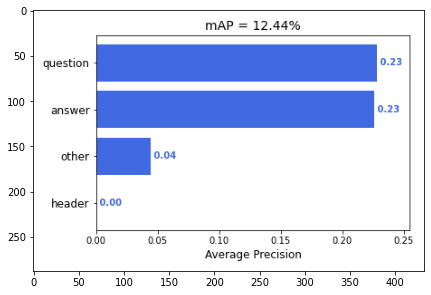

In [82]:
mostrarImagen(abrirImagen('output/mAP.png'),7,5)

### Predicción

In [ ]:
input/detection-results/01.txt

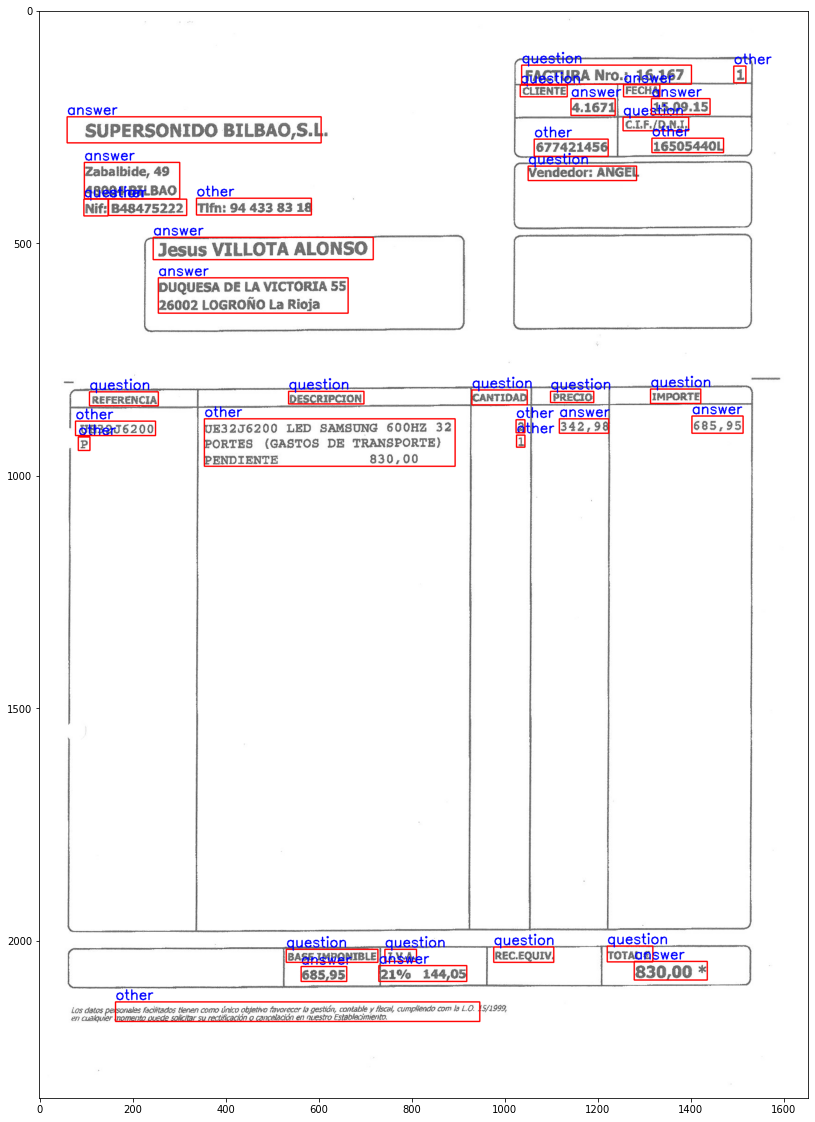

In [87]:
f=Path('Facturas/01.jpg')
img=abrirImagen(f)
clone=img.copy()
txt_pred=open('input/detection-results/01.txt')
linea_pred=txt_pred.readline() 
while linea_pred!='':
  logit,conf,x1,y1,z1,w1=linea_pred.split()
  linea_pred=txt_pred.readline()
  cv2.rectangle(clone, (int(x1), int(y1)), (int(z1),int(w1)), (0, 0, 255), 2)
  cv2.putText(clone, f'{logit}', (int(x1),int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
mostrarImagen(clone,30,20)

In [ ]:
cv2.imwrite('yoloBERT.png',clone)

True